In [109]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from mpl_toolkits import mplot3d
from kneed import KneeLocator
from sklearn.linear_model import LinearRegression
import copy

In [110]:
covid_df = pd.read_csv('./data/covid_archive/country_wise_latest.csv');
h1n1_df = pd.read_csv('./h1n1_archive/data.csv');
city_country_relation = pd.read_csv('./quality_of_life_archive/cities.csv');
city_df = pd.read_csv('./quality_of_life_archive/movehubqualityoflife.csv');

In [111]:
city_2_country = city_country_relation.set_index('City').to_dict()
city_2_country = city_2_country['Country']


In [112]:
# ['City', 'Movehub Rating', 'Purchase Power', 'Health Care', 'Pollution',
#        'Quality of Life', 'Crime Rating']
country_covid_cases = {}
country_covid_deaths = {}
country_covid_deathsper100cases = {}
country_covid_deathsper100recovered={}
country_h1n1_cases = {}
country_healthcare_rating = {}
country_pollution_rating = {}
country_qualityOfLife_rating = {}
country_Movehub_rating = {}
country_Purachase_power = {}
country_Crime_rating = {}
city_country_ct = {} # For the quality of life measurements, broken down by city but trying to aggregate by country

In [113]:
for index,row in covid_df.iterrows():
    country_covid_cases[row["Country/Region"]] = int(row["Confirmed"])
    country_covid_deaths[row["Country/Region"]] = int(row["Deaths"])
    if(row["Deaths / 100 Recovered"] != math.inf):
        country_covid_deathsper100recovered[row["Country/Region"]]=int(row["Deaths / 100 Recovered"])
    country_covid_deathsper100cases[row["Country/Region"]] = int(row["Deaths / 100 Cases"])
    

for index,row in h1n1_df.iterrows():
    if country_h1n1_cases.get(row["Country"]) == None:
        country_h1n1_cases[row["Country"]] = row['Cumulative no. of cases']
    elif row['Cumulative no. of cases'] > country_h1n1_cases[row["Country"]]:
        country_h1n1_cases[row["Country"]] = row['Cumulative no. of cases']



In [114]:
for index, row in city_df.iterrows():
    
    #Edge case differentiation, as some city names are stored different in the association table
    k = row["City"]
    if k == "Philadelphia":
        k = "Philadelphia, Pennsylvania"
    elif k == "Rio De Janeiro":
        k = "Rio de Janeiro"
    elif k == "Sao Paulo":
        k = "São Paulo"
    elif k == "Miami":
        k = "Miami, Florida"
    elif city_2_country.get(k) == None:
        continue
    
    #below is a moving average calculation
    country = city_2_country[k]
    if city_country_ct.get(country) == None or city_country_ct[country] == 0:
        city_country_ct[country] = 1
    else:
        city_country_ct[country] = city_country_ct[country] + 1
    
    if city_country_ct[country] == 1:
#         ['City', 'Movehub Rating', 'Purchase Power', 'Health Care', 'Pollution',
#        'Quality of Life', 'Crime Rating']
        country_healthcare_rating[country] = row['Health Care']
        country_pollution_rating[country] = row['Pollution']
        country_qualityOfLife_rating[country] = row['Quality of Life']
        country_Movehub_rating[country] = row['Movehub Rating']
        country_Purachase_power[country] = row['Purchase Power']
        country_Crime_rating[country] = row['Crime Rating']
    else:
        prev_res_h = (city_country_ct[country] - 1) * (country_healthcare_rating[country])
        prev_res_p = (city_country_ct[country] - 1) * (country_pollution_rating[country])
        prev_res_q = (city_country_ct[country] - 1) * (country_qualityOfLife_rating[country])
        prev_res_m = (city_country_ct[country] - 1) * (country_Movehub_rating[country])
        prev_res_pp = (city_country_ct[country] - 1) * (country_Purachase_power[country])
        prev_res_c = (city_country_ct[country] - 1) * (country_Crime_rating[country])
        
        curr_res_h = prev_res_h + row['Health Care']
        curr_res_p = prev_res_p + row['Pollution']
        curr_res_q = prev_res_q + row['Quality of Life']
        curr_res_m = prev_res_m + row['Movehub Rating']
        curr_res_pp = prev_res_pp + row['Purchase Power']
        curr_res_c = prev_res_c + row['Crime Rating']
        
        country_healthcare_rating[country] = curr_res_h / city_country_ct[country]
        country_pollution_rating[country] = curr_res_p / city_country_ct[country]
        country_qualityOfLife_rating[country] = curr_res_q / city_country_ct[country]
        country_Movehub_rating[country] = curr_res_m / city_country_ct[country]
        country_Purachase_power[country] = curr_res_pp / city_country_ct[country]
        country_Crime_rating[country] = curr_res_c / city_country_ct[country]


In [115]:
for i in country_covid_cases.keys():
    if i not in(country_healthcare_rating.keys()):
        country_healthcare_rating[i]=0
        
        
for i in (country_healthcare_rating.keys()):
    if i not in(country_covid_cases.keys()):
        country_covid_cases[i]=0

    
print(len(country_healthcare_rating.keys()))
print(len(country_covid_cases.keys()))

191
191


In [116]:
#Finding IQR for the following country_covid_deathsper100recovered,covid_deathsper100cases, and covid_deaths

deathsper100recovered =[]
deathsper100cases=[]
deaths=[]
totalccases=[]

print(country_covid_cases)
for i in country_covid_deathsper100recovered.keys():
    deathsper100recovered.append(country_covid_deathsper100recovered[i])
for i in country_covid_deathsper100cases.keys():
    deathsper100cases.append(country_covid_deathsper100cases[i])
for i in country_covid_deaths.keys():
    deaths.append(country_covid_deaths[i])
for i in country_covid_cases.keys():
    totalccases.append(country_covid_cases[i])


q75, q25 = np.percentile(deathsper100recovered, [75 ,25])
iqr = q75 - q25
ye = (1.5*iqr)+q75
print((1.5*iqr)+q75)

print(q25-(1.5*iqr))

d2 = copy.deepcopy( country_covid_deathsper100recovered)
for i in country_covid_deathsper100recovered.keys():
    if( country_covid_deathsper100recovered[i]>= ye):
         d2.pop(i)
country_covid_deathsper100recovered = d2


{'Afghanistan': 36263, 'Albania': 4880, 'Algeria': 27973, 'Andorra': 907, 'Angola': 950, 'Antigua and Barbuda': 86, 'Argentina': 167416, 'Armenia': 37390, 'Australia': 15303, 'Austria': 20558, 'Azerbaijan': 30446, 'Bahamas': 382, 'Bahrain': 39482, 'Bangladesh': 226225, 'Barbados': 110, 'Belarus': 67251, 'Belgium': 66428, 'Belize': 48, 'Benin': 1770, 'Bhutan': 99, 'Bolivia': 71181, 'Bosnia and Herzegovina': 10498, 'Botswana': 739, 'Brazil': 2442375, 'Brunei': 141, 'Bulgaria': 10621, 'Burkina Faso': 1100, 'Burma': 350, 'Burundi': 378, 'Cabo Verde': 2328, 'Cambodia': 226, 'Cameroon': 17110, 'Canada': 116458, 'Central African Republic': 4599, 'Chad': 922, 'Chile': 347923, 'China': 86783, 'Colombia': 257101, 'Comoros': 354, 'Congo (Brazzaville)': 3200, 'Congo (Kinshasa)': 8844, 'Costa Rica': 15841, "Cote d'Ivoire": 15655, 'Croatia': 4881, 'Cuba': 2532, 'Cyprus': 1060, 'Czechia': 15516, 'Denmark': 13761, 'Djibouti': 5059, 'Dominica': 18, 'Dominican Republic': 64156, 'Ecuador': 81161, 'Egypt'

In [117]:
q75, q25 = np.percentile(deathsper100cases, [75 ,25])
iqr = q75 - q25
ye = (1.5*iqr)+q75
print((1.5*iqr)+q75)
print(q25-(1.5*iqr))

d2 = copy.deepcopy( country_covid_deathsper100cases)
for i in country_covid_deathsper100cases.keys():
    if( country_covid_deathsper100cases[i]>= ye):
         d2.pop(i)
country_covid_deathsper100cases = d2


7.5
-4.5


In [118]:
q75, q25 = np.percentile(deaths, [75 ,25])
iqr = q75 - q25
ye = (1.5*iqr)+q75
print((1.5*iqr)+q75)
print(q25-(1.5*iqr))
d2 = copy.deepcopy( country_covid_deaths)
for i in country_covid_deaths.keys():
    if( country_covid_deaths[i]>= ye):
         d2.pop(i)
country_covid_deaths = d2


1807.25
-1054.75


In [119]:
q75, q25 = np.percentile(totalccases, [75 ,25])
iqr = q75 - q25
ye = (1.5*iqr)+q75
print((1.5*iqr)+q75)
print(q25-(1.5*iqr))
d2 = copy.deepcopy(country_covid_cases)
for i in country_covid_cases.keys():
    if( country_covid_cases[i]>= ye):
         d2.pop(i)
country_covid_cases = d2

print(ye)

97624.75
-57077.25
97624.75


In [121]:
#country_covid_cases



allFeatures = {}

# Healthcare
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_pollution_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_pollution_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Healthcare Rating'] = [X,y]

# Pollution
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_healthcare_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_healthcare_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Pollution Rating'] = [X,y]

# Quality of Life
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_qualityOfLife_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_qualityOfLife_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Quality of Life'] = [X,y]

# Movehub Rating
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_Movehub_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_Movehub_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Movehub Rating'] = [X,y]

# Purachase Power
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_Purachase_power.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_Purachase_power[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Purchase Power'] = [X,y]

# Crime Rating
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_Crime_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_Crime_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Crime Rating'] = [X,y]

# Pollution Rating
vals = {}
cases = {}
for cN in country_covid_cases.keys():
    if cN in country_pollution_rating.keys():
        vals[cN] = country_covid_cases[cN]
        cases[cN] = country_pollution_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures['Pollution Rating'] = [X,y]


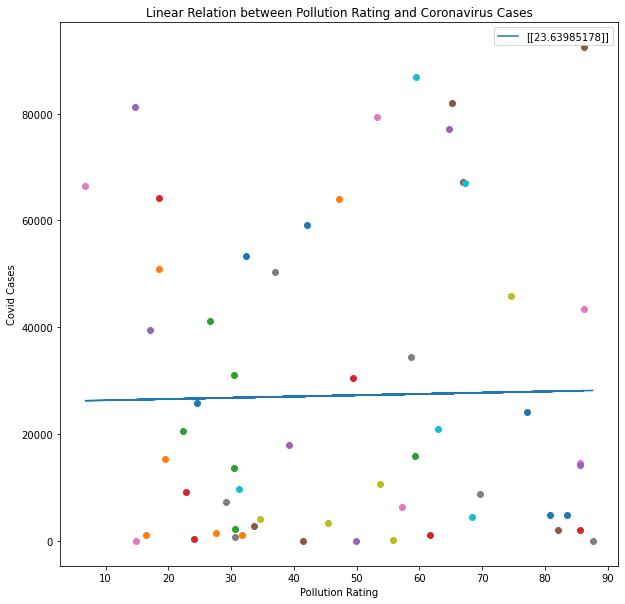

In [124]:
reg_mod = LinearRegression().fit(allFeatures["Pollution Rating"][1], allFeatures["Pollution Rating"][0]);
# print(allFeatures["Movehub Rating"][0])
# for x in allFeatures["Movehub Rating"][0]:
#     print(x[0])
reg_line = [reg_mod.predict([[x[0]]])[0][0] for x in allFeatures["Pollution Rating"][1]]

# print(reg_line)
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(allFeatures["Pollution Rating"][1], reg_line, label = reg_mod.coef_);
for i in range(len(reg_line)):
    plt.scatter(allFeatures["Pollution Rating"][1][i], allFeatures["Pollution Rating"][0][i]);
ax.set_xlabel("Pollution Rating")
ax.set_ylabel("Covid Cases")
ax.set_title("Linear Relation between Pollution Rating and Coronavirus Cases")
plt.legend()

plt.show()

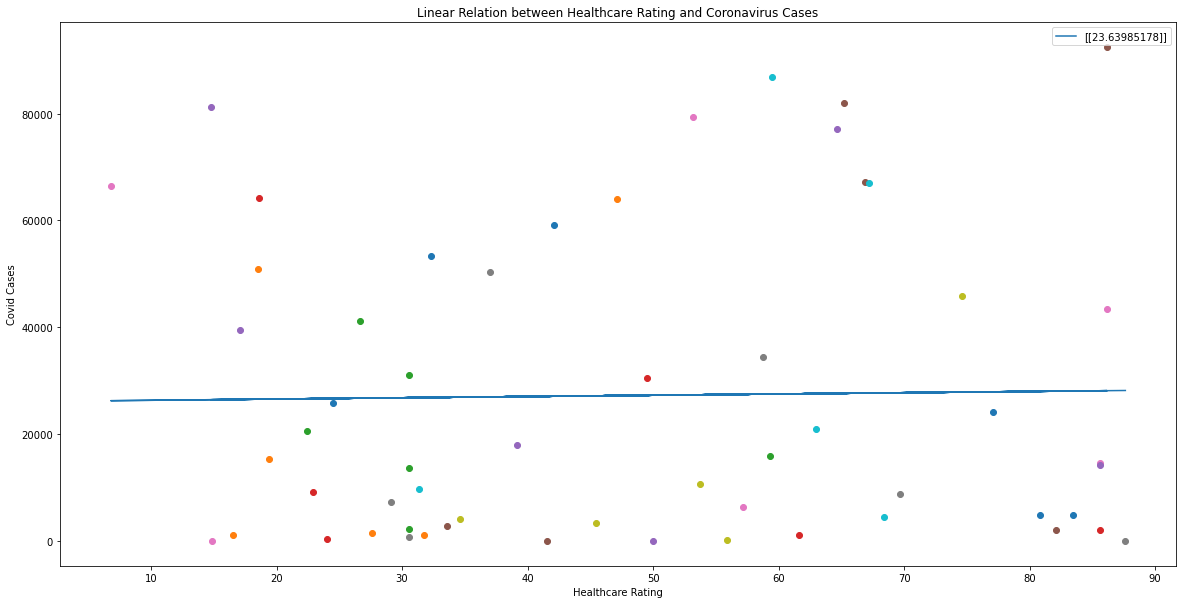

In [106]:


reg_mod = LinearRegression().fit(allFeatures["Healthcare Rating"][1], allFeatures["Healthcare Rating"][0]);
# print(allFeatures["Movehub Rating"][0])
# for x in allFeatures["Movehub Rating"][0]:
#     print(x[0])
reg_line = [reg_mod.predict([[x[0]]])[0][0] for x in allFeatures["Healthcare Rating"][1]]

# print(reg_line)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(allFeatures["Healthcare Rating"][1], reg_line, label = reg_mod.coef_);
for i in range(len(reg_line)):
    plt.scatter(allFeatures["Healthcare Rating"][1][i], allFeatures["Healthcare Rating"][0][i]);
ax.set_xlabel("Healthcare Rating")
ax.set_ylabel("Covid Cases")
ax.set_title("Linear Relation between Healthcare Rating and Coronavirus Cases")
plt.legend()

plt.show()

In [107]:
#country_covid_deaths



allFeatures2 = {}

# Healthcare
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_pollution_rating.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_pollution_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Healthcare Rating'] = [X,y]

# Pollution
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_healthcare_rating.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_healthcare_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Pollution Rating'] = [X,y]

# Quality of Life
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_qualityOfLife_rating.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_qualityOfLife_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Quality of Life'] = [X,y]

# Movehub Rating
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_Movehub_rating.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_Movehub_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Movehub Rating'] = [X,y]

# Purachase Power
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_Purachase_power.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_Purachase_power[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Purchase Power'] = [X,y]

# Crime Rating
vals = {}
cases = {}
for cN in country_covid_deaths.keys():
    if cN in country_Crime_rating.keys():
        vals[cN] = country_covid_deaths[cN]
        cases[cN] = country_Crime_rating[cN]
X, y = np.array(list(vals.values())).reshape(-1, 1), np.array(list(cases.values())).reshape(-1, 1)
allFeatures2['Crime Rating'] = [X,y]


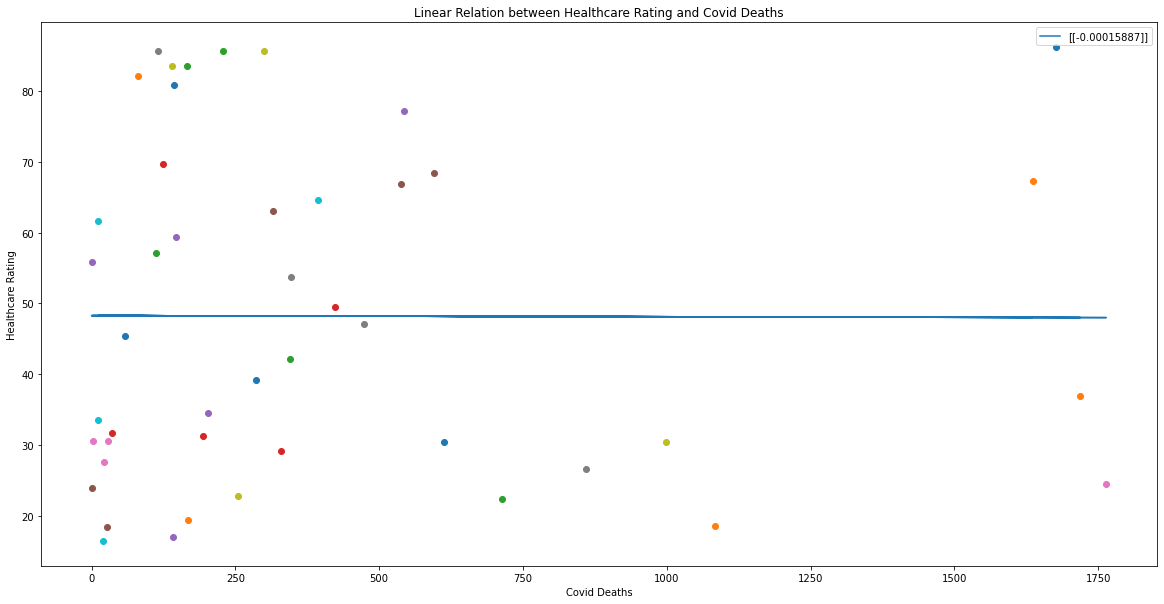

In [86]:
reg_mod = LinearRegression().fit(allFeatures2["Healthcare Rating"][0], allFeatures2["Healthcare Rating"][1]);
# print(allFeatures2["Movehub Rating"][0])
# for x in allFeatures2["Movehub Rating"][0]:
#     print(x[0])
reg_line = [reg_mod.predict([[x[0]]])[0][0] for x in allFeatures2["Healthcare Rating"][0]]

# print(reg_line)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(allFeatures2["Healthcare Rating"][0], reg_line, label = reg_mod.coef_);
for i in range(len(reg_line)):
    plt.scatter(allFeatures2["Healthcare Rating"][0][i], allFeatures2["Healthcare Rating"][1][i]);
ax.set_ylabel("Healthcare Rating")
ax.set_xlabel("Covid Deaths")
ax.set_title("Linear Relation between Healthcare Rating and Covid Deaths")
plt.legend()

plt.show()

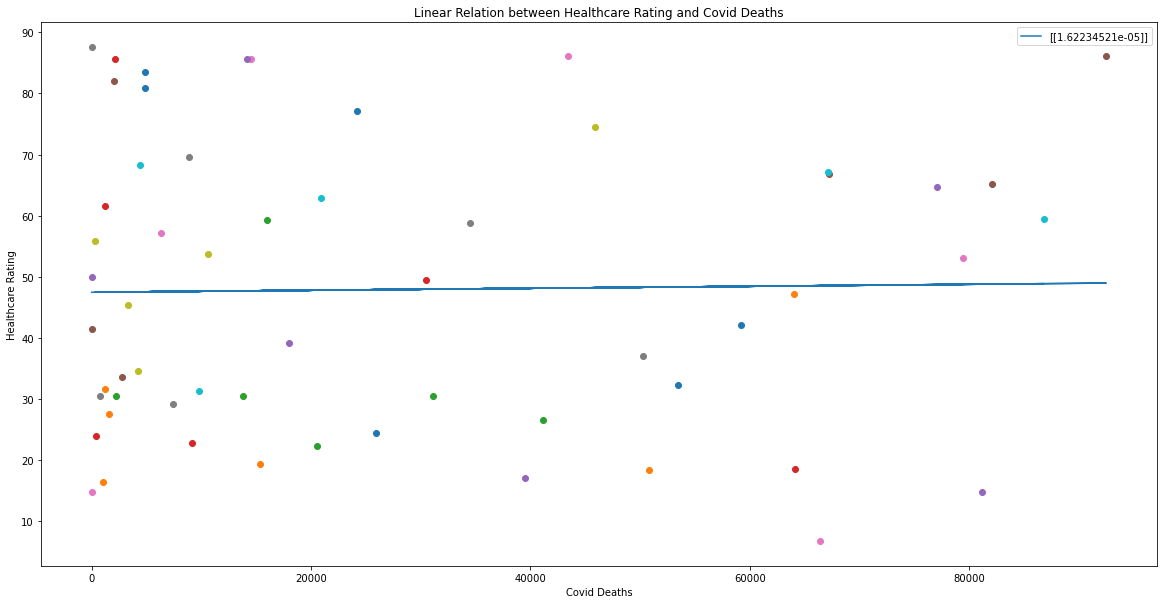

In [87]:
reg_mod = LinearRegression().fit(allFeatures["Healthcare Rating"][0], allFeatures["Healthcare Rating"][1]);
# print(allFeatures2["Movehub Rating"][0])
# for x in allFeatures2["Movehub Rating"][0]:
#     print(x[0])
reg_line = [reg_mod.predict([[x[0]]])[0][0] for x in allFeatures["Healthcare Rating"][0]]

# print(reg_line)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(allFeatures["Healthcare Rating"][0], reg_line, label = reg_mod.coef_);
for i in range(len(reg_line)):
    plt.scatter(allFeatures["Healthcare Rating"][0][i], allFeatures["Healthcare Rating"][1][i]);
ax.set_ylabel("Healthcare Rating")
ax.set_xlabel("Covid Deaths")
ax.set_title("Linear Relation between Healthcare Rating and Covid Deaths")
plt.legend()

plt.show()